<h2> Preparing the hydro data</h2>

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.ops import nearest_points
import shapely

plt.rcParams.update({
        "font.weight": "bold",  # bold fonts
        "font.size":10,
        "lines.linewidth": 2,   # thick lines
        "grid.color": "0.5",    # gray gridlines
        "grid.linewidth": 0.5,  # thin gridlines
        "savefig.dpi": 300,     # higher resolution output.
        "axes.labelsize" : 15
    })

fig_size = (20,8)

In [39]:
data = pd.read_csv('Data_Folder/Final-discharge-data.csv')
data = data.set_index('Date')
index = pd.date_range('1/1/2014', periods=365, freq='D')
data.index = index
data = data.resample("H").ffill()

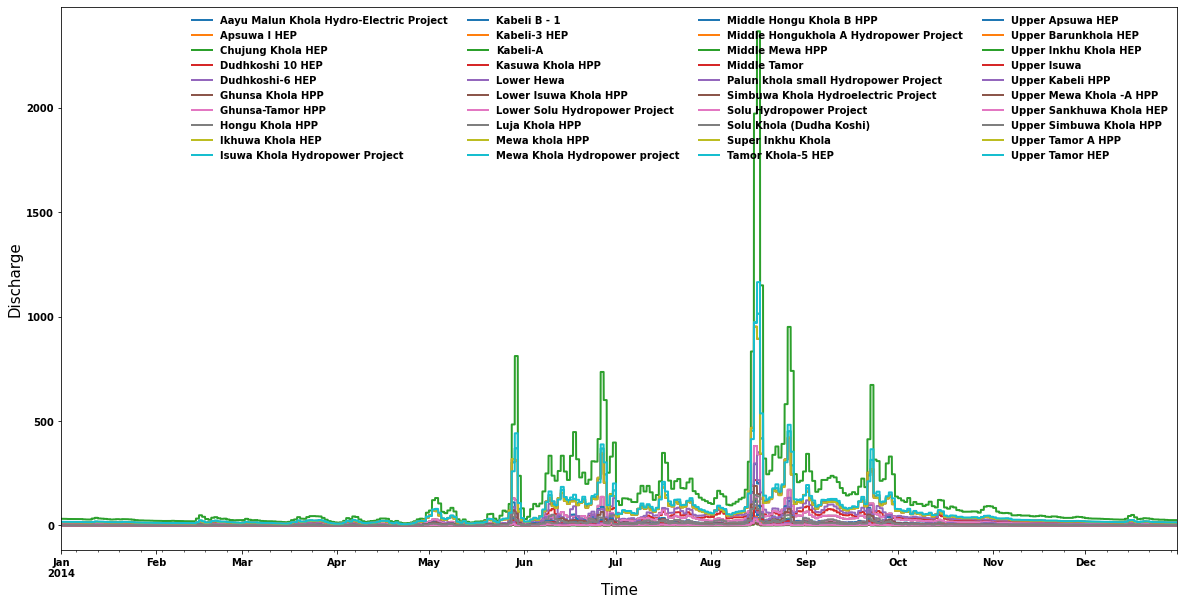

In [67]:
fig_size=(20,10)
fig,ax = plt.subplots(1,1)
fig.set_size_inches(fig_size)

data.plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Discharge")
ax.legend(frameon=False, ncol=4)
#plt.savefig(result_folder+'load_t.png')

In [41]:
def find_Q_des(dat,q_des_percent):
    h_sort = dat.sort_values(by = ['Values'],ascending=False)
    h_sort['cumsums'] = h_sort['Values'].cumsum()
    Q_des = int(len(h_sort)*q_des_percent/100)
    q_des = h_sort.iloc[Q_des].Values
    h_sort['d_des'] = [0.0]*len(h_sort)
    for i in range(len(h_sort)):
        if h_sort.Values[i]<q_des:
            h_sort.d_des[i] = float(h_sort.Values[i])
        if h_sort.Values[i]>=q_des:
            h_sort.d_des[i] = q_des
    
    h_final = h_sort.sort_index()
    return h_final

def normalize_with_Q_des(df,q_des_percent):
    result = df.copy()
    for feature_name in df.columns:
        dat= pd.DataFrame()
        dat['Date'] = df[feature_name].index
        dat['Values'] = df[feature_name].values
        dat = dat.set_index('Date')
        dat_norm = find_Q_des(dat,q_des_percent)
        result[feature_name] = dat_norm['d_des'].values
    return result

design_discharge = 65
data_design=normalize_with_Q_des(data,design_discharge)

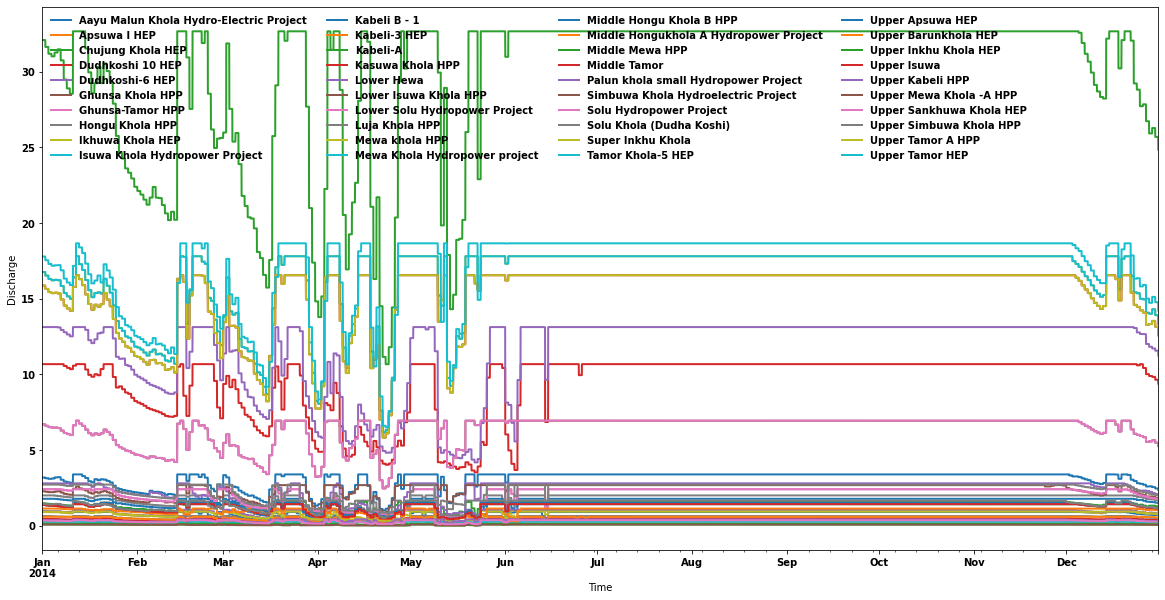

In [42]:
fig_size=(20,10)
fig,ax = plt.subplots(1,1)
fig.set_size_inches(fig_size)

data_design.plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Discharge")
ax.legend(frameon=False, ncol=4)
#plt.savefig(result_folder+'load_t.png')

In [43]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
norm_discharge = normalize(data_design)

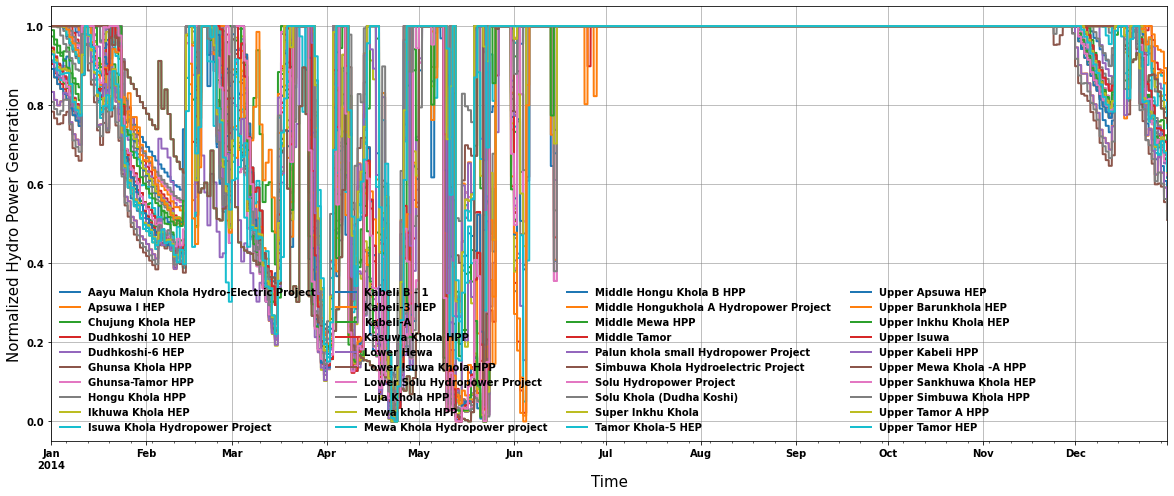

In [68]:
fig_size = (20,8)
fig,ax = plt.subplots(1,1)
fig.set_size_inches(fig_size)

norm_discharge.plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Normalized Hydro Power Generation")
ax.legend(frameon=False, ncol=4)
ax.grid()
plt.savefig("Images/normalize_hydro_generation.jpg",dpi = 300,bbox_inches = 'tight')

<h3>Solar Data Parsing and Analysis</h3>

In [23]:
# Declare all variables as strings. Spaces must be replaced with '+', i.e., change 'John Smith' to 'John+Smith'.

# You must request an NSRDB api key from the link above
api_key = 'PUt8OMN6vPFfyMSuHhYa4Y8vgsuFH5jaetWByYcW'
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes = 'ghi,solar_zenith_angle,wind_speed,air_temperature,dhi,dni'
# Choose year of data
year = '2014'
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'false'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '60'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'Deependra+Neupane'
# Your reason for using the NSRDB.
reason_for_use = 'research'
# Your affiliation
your_affiliation = 'ioe'
# Your email address
your_email = 'deependran.neupane@gmail.com'
# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'true'

def get_ghi_for_lat_lon(lat, lon):
    # Return all but first 2 lines of csv to get data:
    df = pd.read_csv('https://developer.nrel.gov/api/nsrdb/v2/solar/suny-india-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes), skiprows=2)

    # Set the time index in the pandas dataframe:
    df = df.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))

    # take a look
    return [df.index, df.GHI.values]

In [13]:
from pyproj.crs import CRS
crs = CRS(CRS(4326))

In [14]:
solar_site_main = gpd.read_file("Data_Folder/Solar_potential_areas/solar_poa/solar_poa_water_excluded.shp").to_crs(crs)
boundary = gpd.read_file("Data_Folder/Solar_potential_areas/Eastern Grid").to_crs(crs)
#get the eastern area site only
eastern_site = gpd.clip(solar_site_main, boundary)

In [15]:
#eastern_site.to_file("Data_Folder/Solar_potential_areas/eastern_solar.shp")
pot_solar_eastern = gpd.read_file("Data_Folder/Solar_potential_areas/eastern_solar.shp")
pot_solar = pot_solar_eastern.query('incap>=15')
pot_solar['center'] = pot_solar.centroid

lat = [0]*len(pot_solar)
lon = [0]*len(pot_solar)
for i in range(len(pot_solar)):
    x,y=pot_solar.center.iloc[i].coords.xy
    lat[i] = y[0]
    lon[i] = x[0]   
pot_solar['lat'] = lat
pot_solar['lon'] = lon

/tmp/ipykernel_12983/3493157671.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pot_solar['center'] = pot_solar.centroid
/home/deependran/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/deependran/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [24]:
file_s = pd.DataFrame()
file_s['incap'] = pot_solar.incap.values
file_s['lat'] = pot_solar.lat.values
file_s['long'] = pot_solar.lon.values
site_name = []

solar_data = pd.DataFrame()
for i in range(len(file_s)):
    lat = file_s.lat[i]
    lon = file_s.long[i]
    a = get_ghi_for_lat_lon(lat,lon)
    name = 'solar_site_'+ str(i)
    site_name.append(name)
    print("completed for", name)
    solar_data[name] = a[1]
    
file_s['site_name'] = site_name

completed for solar_site_0
completed for solar_site_1
completed for solar_site_2
completed for solar_site_3
completed for solar_site_4
completed for solar_site_5
completed for solar_site_6
completed for solar_site_7
completed for solar_site_8
completed for solar_site_9
completed for solar_site_10
completed for solar_site_11
completed for solar_site_12
completed for solar_site_13
completed for solar_site_14
completed for solar_site_15
completed for solar_site_16
completed for solar_site_17
completed for solar_site_18
completed for solar_site_19


In [26]:
solar_data.index = a[0]
norm_solar_data = normalize(solar_data)

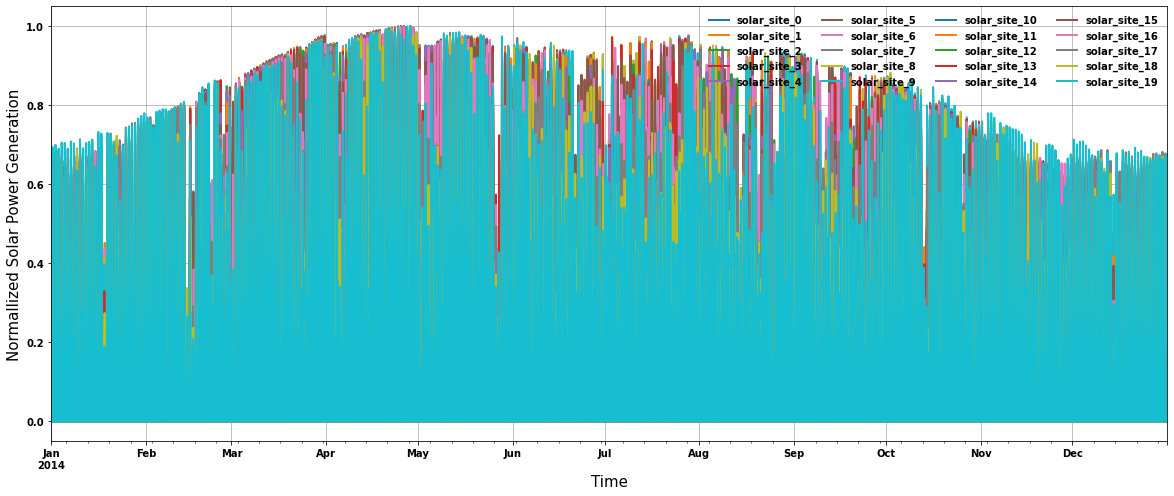

In [69]:
fig_size=(20,8)
fig,ax = plt.subplots(1,1)
fig.set_size_inches(fig_size)

norm_solar_data.plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Normallized Solar Power Generation")
ax.legend(frameon=False, ncol=4)
ax.grid()
plt.savefig("Images/normalize_solar_generation.jpg",dpi = 300,bbox_inches = 'tight')


<h3> Adding the solar data and hydro data to wet and dry data

In [41]:
#merging the solar and discharge data
start_date = norm_discharge.index[0]
end_date = norm_discharge.index[8736]

mask = (norm_solar_data.index >= start_date) & (norm_solar_data.index <= end_date)
norm_sol = norm_solar_data.loc[mask]

Dis_solar_data = norm_discharge.join(norm_sol)
#save the merged files
Dis_solar_data.to_csv('Data_Folder/p_max_pu.csv')
final_data = pd.read_csv('Data_Folder/p_max_pu.csv',index_col=0)
final_data.index = pd.to_datetime(final_data.index)

In [42]:
dry_snapshot = pd.read_csv('Data_Folder/Eastern_grid_data/dry_season_data/snapshots.csv')
wet_snapshot = pd.read_csv('Data_Folder/Eastern_grid_data/wet_season_data/snapshots.csv')

In [43]:
def get_data_from_date_range(dataframe, start_date, end_date):
    mask = (dataframe.index >= start_date) & (dataframe.index <= end_date)
    data = dataframe.loc[mask]
    return data

In [44]:
dry_index1 = pd.date_range('12/16/2014', periods=361, freq='H')
dry_index2 = pd.date_range('1/1/2014', periods=1009, freq='H')
dry1_start = dry_index1[0]
dry1_end = dry_index1[len(dry_index1)-1]
dry2_start = dry_index2[0]
dry2_end = dry_index2[len(dry_index2)-1]

p_pu_dry_data1 = get_data_from_date_range(final_data,dry1_start,dry1_end)
p_pu_dry_data2 = get_data_from_date_range(final_data,dry2_start,dry2_end)

p_pu_dry_data = p_pu_dry_data1.append(p_pu_dry_data2)
p_pu_dry_data.index = pd.date_range('12/16/2014', periods=1370, freq='H')

/tmp/ipykernel_4711/1786581716.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_pu_dry_data = p_pu_dry_data1.append(p_pu_dry_data2)


In [45]:
wet_index = pd.date_range('6/15/2014', periods=1370, freq='H')
wet_start = wet_index[0]
wet_end = wet_index[len(wet_index)-1]
p_pu_wet_data = get_data_from_date_range(final_data,wet_start,wet_end)
p_pu_wet_data.index = pd.date_range('6/15/2019',periods=1370, freq="H")
p_pu_dry_data.index = pd.date_range('12/16/2019', periods=1370, freq='H')

In [46]:
#replace the p_max_pu with new data
p_pu_wet_data.to_csv("Data_Folder/Eastern_grid_data/wet_season_data/generators-p_max_pu.csv")
p_pu_dry_data.to_csv("Data_Folder/Eastern_grid_data/dry_season_data/generators-p_max_pu.csv")

<h3> Prepare the network for analysis

In [47]:
road_site_main = gpd.read_file("Data_Folder/Road_sites").to_crs(crs) 
boundary = gpd.read_file("Data_Folder/Solar_potential_areas/Eastern Grid").to_crs(crs) 
#get the eastern area site only
road_site = gpd.clip(road_site_main, boundary)

In [48]:
def Filter_road_data(road_site):
    gdf_filtered = road_site.copy()

    for i, row in road_site.iterrows():
        if type(row.geometry) == shapely.geometry.collection.GeometryCollection:

            # get the polygon and only keep the polygon 
            for shape in row.geometry:
                if type(shape) == shapely.geometry.linestring.LineString:
                    gdf_filtered.at[i, 'geometry'] = shape
                    break
    return gdf_filtered
    
road_site = Filter_road_data(road_site)

/tmp/ipykernel_12983/881378412.py:8: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for shape in row.geometry:


In [49]:
hydro_sites = gpd.read_file("Data_Folder/Hydro_sites").to_crs(crs) 
bus_sites = gpd.read_file("Data_Folder/Bus_sites").to_crs(crs) 
generators = pd.read_csv("Data_Folder/Eastern_grid_data/dry_season_data/generators.csv")

In [50]:
from shapely.geometry import Point,LineString
from geopy import distance

In [51]:
generators_hydro = gpd.GeoDataFrame()
dim = len(hydro_sites.Project)
generators_hydro['name'] = hydro_sites.Project
generators_hydro['bus'] = [0]*dim
generators_hydro['control'] = ["PV"]*dim
generators_hydro['p_nom'] = hydro_sites.Capacity
generators_hydro['p_set'] = hydro_sites.Capacity
generators_hydro['carrier'] = ["Hydro"]*dim
generators_hydro['sub_dist'] = [0.0]*dim
Geometry = []
for i in range(dim):
    p = Point(hydro_sites.Longitude[i],hydro_sites.Latitude[i])
    Geometry.append(p)
generators_hydro['geometry'] = Geometry
generators_hydro = generators_hydro.set_crs(crs)

In [52]:
t_factor = 1.5
bus_locations = bus_sites.unary_union
for i, name_site in enumerate(generators_hydro.name):
    nearest_bus = nearest_points(generators_hydro.geometry[i],bus_locations)
    for j, bus_loc in enumerate(bus_sites.geometry):
        if nearest_bus[1] == bus_loc:
            generators_hydro['bus'][i] = bus_sites.name[j]
            generators_hydro['sub_dist'][i] = distance.geodesic(generators_hydro.geometry[i].coords[:][0],bus_sites.geometry[j].coords[:][0]).km*t_factor

/tmp/ipykernel_12983/594248666.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generators_hydro['bus'][i] = bus_sites.name[j]
/tmp/ipykernel_12983/594248666.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generators_hydro['sub_dist'][i] = distance.geodesic(generators_hydro.geometry[i].coords[:][0],bus_sites.geometry[j].coords[:][0]).km*t_factor


In [53]:
def min_distance(poa,place):
    place= place.to_crs(poa.crs).unary_union
    dist =[]
    for i,genom in enumerate(poa.geometry):
        nearest_geoms = nearest_points(poa.geometry[i], place)
        min_dist = distance.geodesic(nearest_geoms[0].coords[:][0],nearest_geoms[1].coords[:][0]).km
        dist.append(min_dist)
    return dist

generators_hydro['road_dist'] = min_distance(generators_hydro,road_site)


In [54]:
solar_sites= file_s
dim = len(solar_sites)
generators_solar = gpd.GeoDataFrame()
generators_solar['name'] = solar_sites.site_name
generators_solar['bus'] = [0]*dim
generators_solar['control'] = ['PV']*dim
generators_solar['p_nom'] = solar_sites.incap
generators_solar['p_set'] = solar_sites.incap
generators_solar['carrier'] =['Solar']*dim
generators_solar['sub_dist'] = [0.0]*dim
generators_solar['road_dist'] = [0.0]*dim
Geometry = []
for i in range(dim):
    p = Point(solar_sites.long[i],solar_sites.lat[i])
    Geometry.append(p)
generators_solar['geometry'] = Geometry
generators_solar = generators_solar.set_crs(crs)

In [55]:
t_factor = 1.5
bus_locations = bus_sites.unary_union
for i, name_site in enumerate(generators_solar.name):
    nearest_bus = nearest_points(generators_solar.geometry[i],bus_locations)
    for j, bus_loc in enumerate(bus_sites.geometry):
        if nearest_bus[1] == bus_loc:
            generators_solar['bus'][i] = bus_sites.name[j]
            generators_solar['sub_dist'][i] = distance.geodesic(generators_solar.geometry[i].coords[:][0],bus_sites.geometry[j].coords[:][0]).km*t_factor
            
generators_solar['road_dist'] = min_distance(generators_solar,road_site)

/tmp/ipykernel_12983/2961400186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generators_solar['bus'][i] = bus_sites.name[j]
/tmp/ipykernel_12983/2961400186.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generators_solar['sub_dist'][i] = distance.geodesic(generators_solar.geometry[i].coords[:][0],bus_sites.geometry[j].coords[:][0]).km*t_factor


In [56]:
generators = pd.DataFrame(generators_hydro).append(pd.DataFrame(generators_solar))
generators.drop('geometry', inplace=True, axis=1)
generators = generators.set_index('name')
generators.to_csv('Data_Folder/Eastern_grid_data/dry_season_data/generators.csv')
generators.to_csv('Data_Folder/Eastern_grid_data/wet_season_data/generators.csv')

/tmp/ipykernel_12983/1984144259.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  generators = pd.DataFrame(generators_hydro).append(pd.DataFrame(generators_solar))


In [57]:
p_value = pd.DataFrame()
p_value['x'] = bus_sites.x.to_list()
p_value['y'] = bus_sites.y.to_list()
p_value['name'] = bus_sites.name.to_list()
for i in range(len(p_value)):
    p_value.name[i] = p_value.name[i].rstrip('0123456789_')
p_value = p_value[~p_value.name.duplicated(keep='first')]

x_values = p_value.x.to_list()
y_values = p_value.y.to_list()
names = p_value.name.to_list()

/tmp/ipykernel_12983/4127921688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_value.name[i] = p_value.name[i].rstrip('0123456789_')


<h3>Preparing line data, storage data and transformer data

In [58]:
line_data = pd.read_csv('Data_Folder/lines.csv')
trans_data = pd.read_csv('Data_Folder/transformers.csv')
storage_data = pd.read_csv('Data_Folder/storage_units.csv')

In [59]:
from_b = []
to_b = []
for i in range(len(line_data)):
    for j in range(len(bus_sites)):
        if line_data.bus0[i] == bus_sites.name[j]:
            from_b.append(Point([bus_sites.x[j],bus_sites.y[j]])) 

for i in range(len(line_data)):
    for j in range(len(bus_sites)):
        if line_data.bus1[i] == bus_sites.name[j]:
            to_b.append(Point([bus_sites.x[j],bus_sites.y[j]])) 

line_data['from_bus'] = from_b
line_data['to_bus'] = to_b

/home/deependran/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/deependran/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [60]:
Line_Sites = gpd.GeoDataFrame()
Lines = []
for i in range(len(line_data)):
    line_d = LineString(tuple(line_data.from_bus[i].coords) + tuple(line_data.to_bus[i].coords))
    Lines.append(line_d)
Line_Sites['geometry'] = Lines
Line_Sites = Line_Sites.set_crs(crs)

<h3> Saving the data 

In [61]:
#save the generated datas on datafolder
generators_hydro.to_file('Data_Folder/Geo_Files/generators_hydro.shp')
generators_solar.to_file('Data_Folder/Geo_Files/generators_solar.shp')
bus_sites.to_file('Data_Folder/Geo_Files/bus_sites.shp')
road_site.to_file('Data_Folder/Geo_Files/road_site.shp')
boundary.to_file('Data_Folder/Geo_Files/boundary.shp')
Line_Sites.to_file('Data_Folder/Geo_Files/trans_lines.shp')

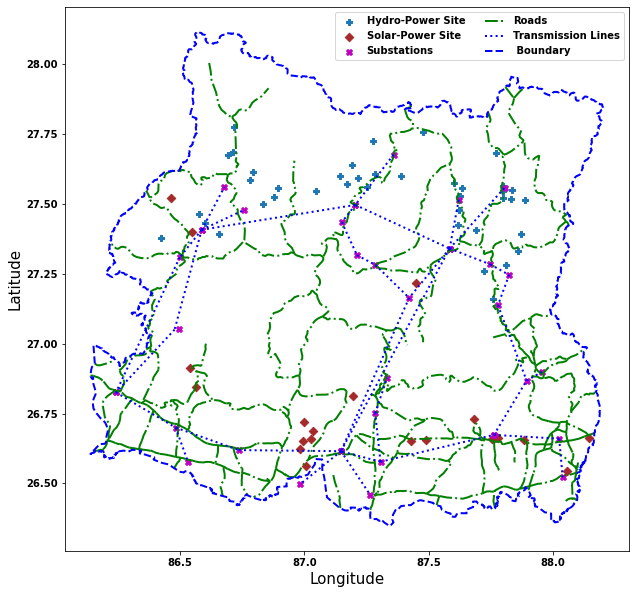

In [70]:
from tkinter.tix import ButtonBox


fig,ax = plt.subplots(figsize = (20,10))
generators_hydro.plot(ax=ax, label="Hydro-Power Site", marker = "P")
generators_solar.plot(ax=ax,label="Solar-Power Site",color = "brown",marker = "D")
bus_sites.plot(ax=ax, label = "Substations", color = 'm',marker = "X")
road_site.plot(ax=ax, label="Roads", color = 'g',linestyle = "dashdot")
Line_Sites.plot(ax=ax,label = "Transmission Lines", color = 'b', linestyle = "dotted")
boundary.exterior.plot(ax=ax, label=" Boundary",color = "b", linestyle = "dashed")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.legend(frameon= True, ncol=2)
plt.savefig('map.pdf',bbox_inches = "tight")
plt.savefig('map.jpg',bbox_inches = "tight")